# wrp-2
`wrp-2` è una modello piu grande e potente di `wrp-1` in grado di individuare dati mancanti e riempirli in modo intelligente, 
queso è possibile perché `wrp-2` è diviso in 2 parti:
- un algoritmo `KNN` che infierisce sui dati riempiendo eventuali buchi
- una rete neurale per apprendimento profondo che stima il peso del gatto

`wrp-2` è in grado di supportare fino ad 1 dato mancante, stimando quale possa essere il valore basandosi su esperienze passate per scegliere come riempire il buco in modo inteligente ed il più vicino alla realtà possibile

In [17]:
import os
from pathlib import Path
import joblib

import pandas as pd
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [18]:
# Carica il dataset completo
df = pd.read_csv("../data/training_set.csv")
binary_columns = ['pelo_lungo', 'sterilizzato', 'vive_interno']  # valori 0/1



# Nelle colonne dove i dati sono binari,
# potrebbero essere presenti dei "Si" e "No"
# o il datatype sbagliato, questa funzione si occupa
# di assicurare che il valore in queste colonne sia sempre e solo 0/1
def ensure_binary(col: pd.Series) -> pd.Series:
    binary_map = {
        1: 1,
        0: 0,
        '1': 1,
        '0': 0,
        'Si': 1,
        'No': 0
    }
    return col.map(binary_map)

# Assicurati che binary_columns abbia solo 0 e 1
for col in binary_columns:
    df[col] = ensure_binary(df[col])


# righe senza nessun valore mancante (per addestrare l'imputer)
df_complete = df.dropna()

# righe con esattamente UN valore mancante (da completare)
rows_with_nan = df[df.isnull().sum(axis=1) == 1].copy()

# righe con più di un valore mancante (opzionale, per ora le scartiamo)
rows_to_discard = df[df.isnull().sum(axis=1) > 1]

print(f"Trovate {len(df_complete)} righe complete.")
print(f"Trovate {len(rows_with_nan)} righe con un valore mancante da imputare.")
print(f"Scartate {len(rows_to_discard)} righe con troppi valori mancanti.")

del df_complete, rows_to_discard, rows_with_nan

Trovate 4869 righe complete.
Trovate 29 righe con un valore mancante da imputare.
Scartate 0 righe con troppi valori mancanti.


In [19]:
def create_imputer(df: pd.DataFrame, n_neighbours: int = 5):
    features = ['eta_mesi', 'razza', 'sesso', 'peso_nascita_kg', 'lunghezza_cm', 
                'altezza_spalla_cm', 'attivita_giornaliera', 'quantita_cibo_giorno_g', 
                'tipo_cibo', 'pelo_lungo', 'sterilizzato', 'temperatura_media_zona', 
                'vive_interno']
    
    categorical_cols = ['razza', 'sesso', 'tipo_cibo']
    
    X_complete = df[features].copy()
    X_complete[categorical_cols] = X_complete[categorical_cols].fillna('Unknown')

    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_complete[categorical_cols] = encoder.fit_transform(X_complete[categorical_cols])

    imputer = KNNImputer(n_neighbors=n_neighbours)
    imputer.fit(X_complete)

    return imputer, encoder


In [20]:
def crate_preprocessor(df: pd.DataFrame):
    categorical_columns = ['razza', 'sesso', 'tipo_cibo'] # puramente stringe di testo
    binary_columns = ['pelo_lungo', 'sterilizzato', 'vive_interno']  # valori 0/1
    numerical_columns = df.columns.drop(categorical_columns + binary_columns).tolist() # valori numerici


    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),
            ('bin', 'passthrough', binary_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
        ])
    preprocessor.fit(df)
    return preprocessor

In [21]:
class DataEncoder:
    def __init__(self, imputer: KNNImputer, ord_encoder: OrdinalEncoder, preprocessor: ColumnTransformer):
        self.imputer = imputer
        self.ord_encoder = ord_encoder
        self.preprocessor = preprocessor

    def __call__(self, df: pd.DataFrame):
        return self.process(df)

    def process(self, df: pd.DataFrame):
        df = self._impute_missing_data(df)
        df_clean, ids = self._preprocess_data(df)
        X_processed = self.preprocessor.transform(df_clean)
        return X_processed, ids
        

    def _impute_missing_data(self, df: pd.DataFrame) -> pd.DataFrame:
        # Seleziona solo le feature dal set di dati completo
        features = ['eta_mesi', 'razza', 'sesso', 'peso_nascita_kg', 'lunghezza_cm', 
                    'altezza_spalla_cm', 'attivita_giornaliera', 'quantita_cibo_giorno_g', 
                    'tipo_cibo', 'pelo_lungo', 'sterilizzato', 'temperatura_media_zona', 
                    'vive_interno']
        categorical_cols = ['razza', 'sesso', 'tipo_cibo']

        
        df_complete = df.dropna()
        rows_with_nan = df[df[features].isnull().any(axis=1)].copy()
        
        # prepara il set con i dati mancanti
        X_to_impute = rows_with_nan[features].copy()
        X_to_impute[categorical_cols] = X_to_impute[categorical_cols].fillna('Unknown')
        X_to_impute[categorical_cols] = self.ord_encoder.transform(X_to_impute[categorical_cols])

        # applica l'imputer per riempire i valori mancanti
        X_imputed_array = self.imputer.transform(X_to_impute)
        df_imputed = pd.DataFrame(X_imputed_array, columns=features)

        # riconverti le colonne categoriche al loro formato originale
        for col in categorical_cols:
            df_imputed[col] = df_imputed[col].round().astype(int)
        df_imputed[categorical_cols] = self.ord_encoder.inverse_transform(df_imputed[categorical_cols])

        # Aggiungi di nuovo l'ID del gatto e il peso
        df_imputed['id_gatto'] = rows_with_nan['id_gatto'].values
        try:
            df_imputed['peso_adulto_kg'] = rows_with_nan['peso_adulto_kg'].values
        except:
            pass
        return pd.concat([df_complete, df_imputed], ignore_index=True)
    
    def _preprocess_data(self, df: pd.DataFrame):
        df_clean = df.copy()
        
        # Rimuovi id_gatto
        if 'id_gatto' in df_clean.columns:
            ids = df_clean['id_gatto'].astype(int)
            df_clean = df_clean.drop(columns=['id_gatto'])
        else:
            ids = range(len(df_clean))
        
        # Gestisci valori mancanti numerici
        numeric_cols = ['eta_mesi', 'peso_nascita_kg', 'lunghezza_cm', 'altezza_spalla_cm', 
                    'attivita_giornaliera', 'quantita_cibo_giorno_g', 'temperatura_media_zona']
        
        for col in numeric_cols:
            if col in df_clean.columns:
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                df_clean[col] = df_clean[col].fillna(df_clean[col].median() if not df_clean[col].isna().all() else 0)
        
        # Gestisci valori mancanti binari
        binary_cols = ['pelo_lungo', 'sterilizzato', 'vive_interno']
        for col in binary_cols:
            if col in df_clean.columns:
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                df_clean[col] = df_clean[col].fillna(0)
                df_clean[col] = df_clean[col].apply(lambda x: 1 if x == 1 else 0)
        
        # Gestisci categorie sconosciute
        categorical_cols = ['razza', 'sesso', 'tipo_cibo']
        for col in categorical_cols:
            if col in df_clean.columns:
                df_clean[col] = df_clean[col].fillna('Unknown')
                # Converti a stringa per sicurezza
                df_clean[col] = df_clean[col].astype(str)
        
        return df_clean, ids
    
    def _ensure_binary(col: pd.Series) -> pd.Series:
        """
        Nelle colonne dove i dati sono binari,
        potrebbero essere presenti dei "Si" e "No"
        o il datatype sbagliato, questa funzione si occupa
        di assicurare che il valore in queste colonne sia sempre e solo 0/1
        """
        binary_map = {
            1: 1,       0: 0,
            '1': 1,     '0': 0,
            'Si': 1,    'No': 0
        }
        return col.map(binary_map)

# usa lo stesso ColumnTransformer di wrp-1
preprocessor: ColumnTransformer = joblib.load("../models/wrp-1/preprocessor.pkl")
data_encoder = DataEncoder(*create_imputer(df.drop(columns=['id_gatto', 'peso_adulto_kg'])), preprocessor)

In [22]:
data_encoder._impute_missing_data(df).isnull().sum()

id_gatto                  0
eta_mesi                  0
razza                     0
sesso                     0
peso_nascita_kg           0
lunghezza_cm              0
altezza_spalla_cm         0
attivita_giornaliera      0
quantita_cibo_giorno_g    0
tipo_cibo                 0
pelo_lungo                0
sterilizzato              0
temperatura_media_zona    0
vive_interno              0
peso_adulto_kg            0
dtype: int64

In [23]:
def preprocess_training_data(df: pd.DataFrame):
    df_clean = df.copy()
    
    # Rimuovi colonne non necessarie
    if 'id_gatto' in df_clean.columns:
        df_clean = df_clean.drop(columns=['id_gatto'])
    
    # Gestisci valori mancanti numerici con la mediana
    numeric_cols = ['eta_mesi', 'peso_nascita_kg', 'lunghezza_cm', 'altezza_spalla_cm', 
                   'attivita_giornaliera', 'quantita_cibo_giorno_g', 'temperatura_media_zona']
    for col in numeric_cols:
        if col in df_clean.columns:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            
    # Gestisci le altre colonne (categoriche, binarie) come preferisci,
    # ad esempio riempiendo con una moda o un valore specifico come 'Unknown' o 0
    
    X = df_clean.drop(columns=['peso_adulto_kg'])
    y = df_clean['peso_adulto_kg']
    
    return X, y

# Applica la pulizia
df = data_encoder._impute_missing_data(df)
X, y = preprocess_training_data(df)


In [27]:
del df # non verrà piu usato, quindi possiamo liberare memoria

In [26]:
X_processed = preprocessor.transform(X)
y = y.values

In [28]:
X_processed.shape

(4898, 22)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2)

In [30]:
model = Sequential([
    Input(shape=(X_processed.shape[1],)),
    
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(1024, activation='relu'),
    Dropout(0.3),
    
    Dense(512, activation='relu'),
    Dropout(0.2),
    
    Dense(256, activation='relu'),
    Dropout(0.2),
    
    Dense(128, activation='relu'),
    Dropout(0.1),
    
    Dense(68, activation='relu'),
    Dropout(0.1),
    
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1),
], name='wrp-2')

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

2025-07-31 17:40:23.943593: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


#### Architettura alternativa
```py
model = Sequential([
    Input(shape=(X_processed.shape[1],)),

    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(256, activation='relu'),
    Dropout(0.2),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(68, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(16, activation='relu'),
    Dense(1),
])

model.compile(
optimizer=Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)
```

In [31]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=1e-1,
            patience=10,
            min_lr=1e-6
        )
    ],
)

Epoch 1/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 5.4865 - mae: 1.4219 - val_loss: 0.9787 - val_mae: 0.4356 - learning_rate: 0.0010
Epoch 2/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 4.5235 - mae: 1.2027 - val_loss: 0.6878 - val_mae: 0.4380 - learning_rate: 0.0010
Epoch 3/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 2.7912 - mae: 1.0729 - val_loss: 0.6784 - val_mae: 0.5147 - learning_rate: 0.0010
Epoch 4/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 2.3366 - mae: 0.9804 - val_loss: 0.7164 - val_mae: 0.6559 - learning_rate: 0.0010
Epoch 5/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 1.9765 - mae: 0.9755 - val_loss: 0.3772 - val_mae: 0.5182 - learning_rate: 0.0010
Epoch 6/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 1.3221 - mae: 0.8467 - val_loss: 0.8529 - val_mae: 0.8248 - learning_rate: 0.0010
Epoch 7/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.8952 - mae: 0.7392 - val_loss: 0.1633 - val_mae: 0.3243 - learning_ra

In [32]:
# valutazione 
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

Test Loss (MSE): 0.0949
Test MAE: 0.2414


In [33]:
# Predizione di esempio
predictions = model.predict(X_test[:5])
print("Predizioni vs Valori reali:")
for i in range(5):
    print(f"Predetto: {predictions[i][0]:.2f} kg, Reale: {y_test[i]:.2f} kg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Predizioni vs Valori reali:
Predetto: 4.86 kg, Reale: 5.01 kg
Predetto: 6.33 kg, Reale: 6.55 kg
Predetto: 5.79 kg, Reale: 5.55 kg
Predetto: 4.93 kg, Reale: 5.32 kg
Predetto: 5.54 kg, Reale: 5.12 kg


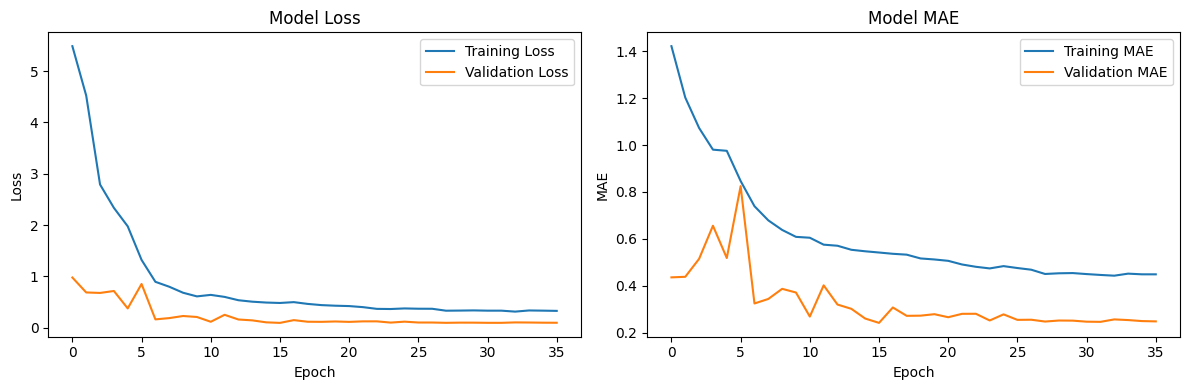

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

### R² score
L'R² Score del modello è molto alto (quasi 1.0) il che vuol dire che è riuscito a generalizzare bene i dati in input

> R² score è una metrica spesso usata per determinare quanto un modello di regressione sia performante.  
>
> Un R² score > 0,85 è gia un risultato buono per un modello, con risultato pari 1.0 a rappresentare un modello perfetto (100% giusto, 0 di errore, estremamente difficile per una rete neurale non andata in overfitting)

In [35]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score: 0.9227


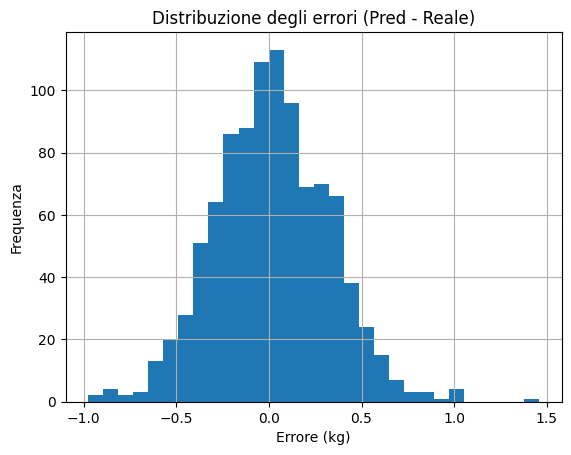

In [36]:
import matplotlib.pyplot as plt

errors = y_pred.flatten() - y_test
plt.hist(errors, bins=30)
plt.title("Distribuzione degli errori (Pred - Reale)")
plt.xlabel("Errore (kg)")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()


Dal grafico possiamo vedere che la maggior parte della distribuzione dell'errore sta attorno a 0,25-0,30 dallo 0 (anche questo un risultato molto buono)

In [37]:
# Architettura del modello
model.summary()

Model: "wrp-2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        23,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 68)             │         8,772 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         1,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,316,209 (20.28 MB)

 Trainable params: 1,772,069 (6.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,544,140 (13.52 MB)

In [38]:

def save_model(model: Sequential, preprocessor: ColumnTransformer, data_encoder: DataEncoder):
    model_name: str = str(model.name)
    dir_path = Path("..") / "models" / model_name
    model_path = dir_path / (model_name + ".keras")
    preprocessor_path = dir_path / "preprocessor.pkl"
    encoder_path = dir_path / (model_name + "-encoder.pkl")

    os.makedirs(model_path.parent, exist_ok=True)

    model.save(model_path)
    joblib.dump(preprocessor, preprocessor_path)
    joblib.dump(data_encoder,encoder_path)

save_model(model, preprocessor, data_encoder)

In [ ]:
model: Sequential = load_model("../models/wrp-2/wrp-2.keras")
encoder: DataEncoder = joblib.load("../models/wrp-2/wrp-2-encoder.pkl")

# Carica test set
test_df = pd.read_csv("../data/test_set.csv")


# processa i dati
X_processed, ids = encoder(test_df)

# determina il peso del gatto
predictions = model.predict(X_processed)

# Salva risultati
os.makedirs("../out", exist_ok=True)
with open("../out/risultati-wrp-2.csv", "w") as out:
    out.write("id_gatto,peso_adulto_kg_previsto\n")
    for id_gatto, peso in zip(ids, predictions):
        out.write(f"{id_gatto},{peso[0]:.2f}\n")

print("✅ Predizioni completate!")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
✅ Predizioni completate!


In [40]:
def mean_absolute_percentage_error(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Computes MAPE — Mean Absolute Percentage Error.

    Returns the average absolute error as a percentage of the true values.
    Ignores zero values in y_true to avoid division by zero.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

predictions = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, predictions.flatten())
print(f"Test MAPE: {mape:.2f}%")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Test MAPE: 4.22%
